In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# some useful functions

def sat_enh(rgb_img, saturation):  # apply "saturation" to image 
    for d in range(3):
        avg = np.average(rgb_img[:,:,d])
        rgb_img[:, :, d] = avg  + saturation*( rgb_img[:, :, d] - avg )
    return rgb_img

def stretch(val, interval_min, interval_max): # stretch values to some interval
    return (val - interval_min) / (interval_max - interval_min)

def logical_mask_to_img(mask, rgb_img): # apply logical mask to select same pixels from each color component of picture
    int_mask = mask.astype(int)
    return rgb_img * int_mask[:, :, np.newaxis] # better way

def show_me(im): # just show me a picture
    plt.figure(figsize=(10,8))
    plt.imshow(im)
    plt.show()


In [3]:
# load data to variables named from band_names list
datadir = "./demo_data" # insert your dir to images from Sentinel Hub EO Browser(raw bands), named like template below 
                        # Sentinel-2_L2A_{band_name}.png

band_names = ["B02", "B03", "B04", "B08", "B11", "B12"] # for this task we need only these bands from Sentinel data
for bn in band_names:
    fname = f'{datadir}/Sentinel-2_L2A_{bn}.png'
    locals()[bn] = np.array(Image.open(fname)) / 255    # to create variables with a name from band_names' list. With a help of locals() 
    

### Highlight fire on image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


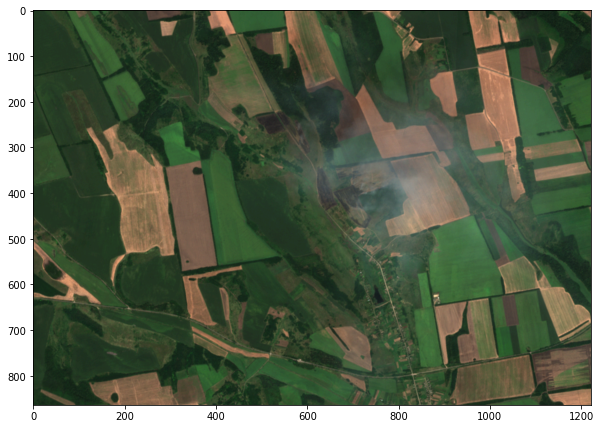

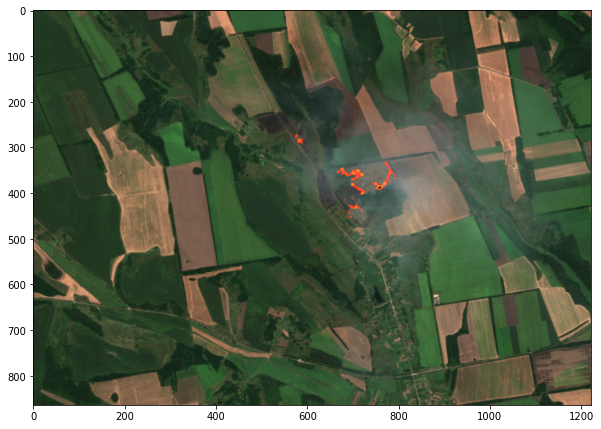

In [7]:
fireSensitivity = 1.0 # bigger value will bring bigger false positives

# params to enhance picture, ie stretchMax < 1 --> increased brightness
stretchMin = 0.0
stretchMax = 0.7
saturation = 1


# compose RGB from particular bands, enhance (stretch) B04 is Red, B03 is Green, B02 is Blue 
# initial "natural color" image
rgb = np.dstack((stretch(2.9*B04, stretchMin, stretchMax), 
                 stretch(2.9*B03, stretchMin, stretchMax), 
                 stretch(2.9*B02, stretchMin, stretchMax) )) 


show_me(rgb) # test


# desaturate (TODO: don't work correctly now, imo)
rgb_final = sat_enh(rgb.copy(), saturation)


# the magic is here: data about fires will be obtained from B12 & B11 SWIR bands
swir_sum = B12 + B11 

# main logic. by changing thresholds we obtain different "types of fire" 
mask_fire3 = swir_sum >  2.0/fireSensitivity # mask for most powerful fire, edge of burning mass
mask_fire2 = (swir_sum > 1.5/fireSensitivity) & (swir_sum < 2/fireSensitivity) # medium one
mask_fire1 = (swir_sum >= 1.0/fireSensitivity) & (swir_sum < 1.5/fireSensitivity) # lightest fire
mask_rgb = swir_sum < 1.0/fireSensitivity # all other pixels are from background rgb picture


# Again, kudos to @pierre_markuse here
# Here we compose colors for different types of fire
fire1 = np.dstack((   stretch(2.1 * B04 + 0.5 * B12, 0.01, 0.99) + 1.1, 
                      stretch(2.2 * B03 + 0.5 * B08, 0.01, 0.99),
                      stretch(2.1 * B02,             0.01, 0.99) ))

fire2 = np.dstack((   stretch(2.1 * B04 + 0.5 * B12, 0.01, 0.99) + 1.1,
                      stretch(2.2 * B03 + 0.5 * B08, 0.01, 0.99) + 0.25,
                      stretch(2.1 * B02, 0.01, 0.99) ))

fire3 = np.dstack((   stretch(2.1 * B04 + 0.5 * B12, 0.01, 0.99) + 1.1,
                      stretch(2.2 * B03 + 0.5 * B08, 0.01, 0.99) + 0.5,
                      stretch(2.1 * B02, 0.01, 0.99) ))


# compose from 4 layers, original rgb & 3 types of fire
final_composite = (logical_mask_to_img(mask_rgb, rgb_final) + # all pixels from background rgb picture
                   logical_mask_to_img(mask_fire1, fire1) +   # where to put pixels for fire1
                   logical_mask_to_img(mask_fire2, fire2) +   # where to put pixels for fire2
                   logical_mask_to_img(mask_fire3, fire3))    # where to put pixels for fire3
                  

final_composite[final_composite > 1] = 1    
    
show_me(final_composite) # final result